# Crop season prediction and deployment

In [10]:
# importing important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline

import optuna
import pickle
import joblib

import warnings
warnings.filterwarnings('ignore')

In [11]:
data = pd.read_csv('Crop_Data.csv')
data

,temperature,humidity,ph,water availability,harvest season,label,Country
0,20.879744,82.002744,6.502985,202.935536,rainy,rice,Nigeria
1,21.770462,80.319644,7.038096,226.655537,rainy,rice,Nigeria
2,23.004459,82.320763,7.840207,263.964248,rainy,rice,Nigeria
3,26.491096,80.158363,6.980401,242.864034,rainy,rice,Nigeria
4,20.130175,81.604873,7.628473,262.717340,rainy,rice,Nigeria
...,...,...,...,...,...,...,...
1395,23.874845,86.792613,6.718725,177.514731,rainy,jute,South Africa
1396,23.928879,88.071123,6.880205,154.660874,rainy,jute,South Africa
1397,24.814412,81.686889,6.861069,190.788639,rainy,jute,Nigeria
1398,24.447439,82.286484,6.769346,190.968489,rainy,jute,Nigeria


In [12]:
data.loc[data['harvest season'] == 'summer']

,temperature,humidity,ph,water availability,harvest season,label,Country
500,27.910952,64.709306,3.692864,32.678919,summer,mothbeans,Nigeria
501,27.322206,51.278688,4.371746,36.503791,summer,mothbeans,Nigeria
502,28.660242,59.318912,8.399136,36.926297,summer,mothbeans,Nigeria
503,29.029553,61.093875,8.840656,72.980166,summer,mothbeans,South Africa
504,27.780315,54.650300,8.153023,32.050253,summer,mothbeans,Nigeria
...,...,...,...,...,...,...,...
1195,29.527531,94.574594,6.700338,21.135457,summer,muskmelon,Kenya
1196,28.504164,93.468065,6.565313,24.200072,summer,muskmelon,Nigeria
1197,28.895786,94.789930,6.286515,23.036250,summer,muskmelon,Nigeria
1198,27.049275,91.382173,6.448062,23.657475,summer,muskmelon,South Africa


In [13]:
for feature in data.columns:
    print(data[feature].value_counts())

temperature
25.337977    2
21.869274    2
23.391282    2
18.419330    2
20.273171    2
            ..
20.046118    1
19.542849    1
29.650529    1
29.377356    1
26.574217    1
Name: count, Length: 1300, dtype: int64
humidity
68.498360    2
61.910449    2
61.744272    2
64.235803    2
63.912819    2
            ..
48.939056    1
66.347773    1
42.898332    1
44.822946    1
73.819949    1
Name: count, Length: 1300, dtype: int64
ph
6.586245    2
5.850440    2
5.871648    2
6.474477    2
6.439072    2
           ..
4.567446    1
6.151029    1
6.876573    1
6.842744    1
7.261581    1
Name: count, Length: 1300, dtype: int64
water availability
96.463802     2
107.268193    2
107.319813    2
76.413124     2
62.503519     2
             ..
122.456420    1
173.110698    1
186.922605    1
172.401680    1
159.322307    1
Name: count, Length: 1300, dtype: int64
harvest season
rainy     600
winter    400
summer    300
spring    100
Name: count, dtype: int64
label
maize          200
rice           

In [14]:
data.describe()

,temperature,humidity,ph,water availability
count,1400.000000,1400.000000,1400.000000,1400.000000
mean,24.971621,64.611062,6.565246,91.784651
std,4.081622,22.753785,0.835101,58.682258
min,15.330426,14.258040,3.504752,20.211267
25%,22.178239,56.824217,6.068795,51.546542
50%,25.140245,68.288321,6.524478,72.379183
75%,27.963227,82.710409,7.042343,107.428334
max,36.977944,94.962187,9.935091,298.560117


In [15]:
data.rename(columns = {'water availability': 'water_availability', 'harvest season': 'harvest_season', 'Country': 'country', 'label': 'crop'}, inplace= True)
data

,temperature,humidity,ph,water_availability,harvest_season,crop,country
0,20.879744,82.002744,6.502985,202.935536,rainy,rice,Nigeria
1,21.770462,80.319644,7.038096,226.655537,rainy,rice,Nigeria
2,23.004459,82.320763,7.840207,263.964248,rainy,rice,Nigeria
3,26.491096,80.158363,6.980401,242.864034,rainy,rice,Nigeria
4,20.130175,81.604873,7.628473,262.717340,rainy,rice,Nigeria
...,...,...,...,...,...,...,...
1395,23.874845,86.792613,6.718725,177.514731,rainy,jute,South Africa
1396,23.928879,88.071123,6.880205,154.660874,rainy,jute,South Africa
1397,24.814412,81.686889,6.861069,190.788639,rainy,jute,Nigeria
1398,24.447439,82.286484,6.769346,190.968489,rainy,jute,Nigeria


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400 entries, 0 to 1399
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   temperature         1400 non-null   float64
 1   humidity            1400 non-null   float64
 2   ph                  1400 non-null   float64
 3   water_availability  1400 non-null   float64
 4   harvest_season      1400 non-null   object 
 5   crop                1400 non-null   object 
 6   country             1400 non-null   object 
dtypes: float64(4), object(3)
memory usage: 76.7+ KB


In [17]:
crops = list(np.unique(data['crop']))
print(crops)

['blackgram', 'chickpea', 'cotton', 'jute', 'kidneybeans', 'lentil', 'maize', 'mothbeans', 'mungbean', 'muskmelon', 'pigeonpeas', 'rice', 'watermelon']


In [7]:
countries = list(np.unique(data['country']))
countries

['Kenya', 'Nigeria', 'South Africa', 'Sudan']

In [8]:
plant_season = list(np.unique(data['harvest_season']))
plant_season

['rainy', 'spring', 'summer', 'winter']

In [9]:
harvest_season = list(np.unique(data['harvest_season']))
harvest_season

['rainy', 'spring', 'summer', 'winter']

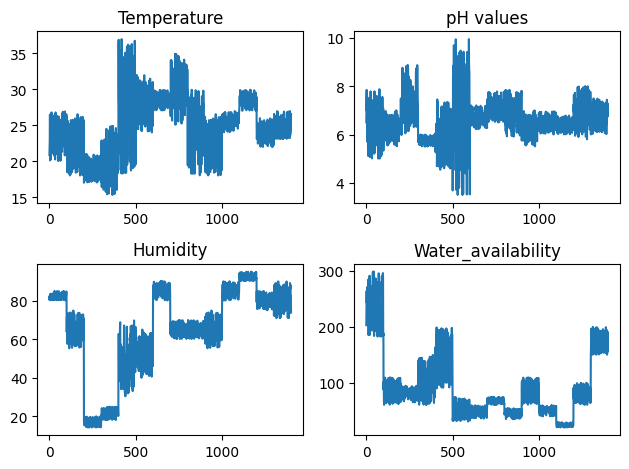

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=2)
ax[0, 0].plot(data['temperature'])
ax[0, 0].set_title('Temperature')

ax[0, 1].plot(data['ph'])
ax[0, 1].set_title('pH values')

ax[1, 0].plot(data['humidity'])
ax[1, 0].set_title('Humidity')

ax[1, 1].plot(data['water_availability'])
ax[1, 1].set_title('Water_availability')

plt.tight_layout()

<Axes: xlabel='harvest_season', ylabel='count'>

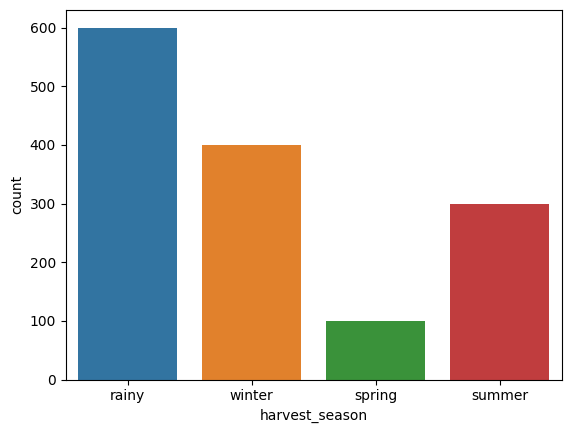

In [11]:
sn.countplot(data, x='harvest_season')

In [12]:
data.duplicated().sum()

0

In [13]:
data.isna().sum()

temperature           0
humidity              0
ph                    0
water_availability    0
harvest_season        0
crop                  0
country               0
dtype: int64

# Data preprocessing

In [14]:
data

,temperature,humidity,ph,water_availability,harvest_season,crop,country
0,20.879744,82.002744,6.502985,202.935536,rainy,rice,Nigeria
1,21.770462,80.319644,7.038096,226.655537,rainy,rice,Nigeria
2,23.004459,82.320763,7.840207,263.964248,rainy,rice,Nigeria
3,26.491096,80.158363,6.980401,242.864034,rainy,rice,Nigeria
4,20.130175,81.604873,7.628473,262.717340,rainy,rice,Nigeria
...,...,...,...,...,...,...,...
1395,23.874845,86.792613,6.718725,177.514731,rainy,jute,South Africa
1396,23.928879,88.071123,6.880205,154.660874,rainy,jute,South Africa
1397,24.814412,81.686889,6.861069,190.788639,rainy,jute,Nigeria
1398,24.447439,82.286484,6.769346,190.968489,rainy,jute,Nigeria


In [15]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [16]:
# planting season
X = data.drop(['harvest_season'], axis = 1)
y = data['harvest_season']

In [17]:
X.columns

Index(['temperature', 'humidity', 'ph', 'water_availability', 'crop',
       'country'],
      dtype='object')

In [18]:
X

,temperature,humidity,ph,water_availability,crop,country
0,20.879744,82.002744,6.502985,202.935536,rice,Nigeria
1,21.770462,80.319644,7.038096,226.655537,rice,Nigeria
2,23.004459,82.320763,7.840207,263.964248,rice,Nigeria
3,26.491096,80.158363,6.980401,242.864034,rice,Nigeria
4,20.130175,81.604873,7.628473,262.717340,rice,Nigeria
...,...,...,...,...,...,...
1395,23.874845,86.792613,6.718725,177.514731,jute,South Africa
1396,23.928879,88.071123,6.880205,154.660874,jute,South Africa
1397,24.814412,81.686889,6.861069,190.788639,jute,Nigeria
1398,24.447439,82.286484,6.769346,190.968489,jute,Nigeria


In [19]:
X['country'].value_counts().sort_index()

country
Kenya           155
Nigeria         713
South Africa    468
Sudan            64
Name: count, dtype: int64

In [20]:
X.replace({'crop':{'blackgram':0,
                 'chickpea': 1,
                 'cotton': 2,
                 'jute':3,
                 'kidneybeans':4,
                 'lentil':5,
                 'maize':6,
                 'mothbeans':7,
                 'mungbean': 8,
                 'muskmelon':9,
                 'pigeonpeas':10,
                 'rice':11,
                 'watermelon':12},
         'country':{'Kenya':0,
                   'Nigeria': 1,
                   'South Africa': 2,
                   'Sudan': 3}}, inplace=True)

In [21]:
season_df = data.copy(deep = True)

le = LabelEncoder()
season_df['harvest_season'] = le.fit_transform(season_df['harvest_season'])
season_df['crop'] = le.fit_transform(season_df['crop'])
season_df['country'] = le.fit_transform(season_df['country'])

In [22]:
season_df

,temperature,humidity,ph,water_availability,harvest_season,crop,country
0,20.879744,82.002744,6.502985,202.935536,0,11,1
1,21.770462,80.319644,7.038096,226.655537,0,11,1
2,23.004459,82.320763,7.840207,263.964248,0,11,1
3,26.491096,80.158363,6.980401,242.864034,0,11,1
4,20.130175,81.604873,7.628473,262.717340,0,11,1
...,...,...,...,...,...,...,...
1395,23.874845,86.792613,6.718725,177.514731,0,3,2
1396,23.928879,88.071123,6.880205,154.660874,0,3,2
1397,24.814412,81.686889,6.861069,190.788639,0,3,1
1398,24.447439,82.286484,6.769346,190.968489,0,3,1


<Axes: >

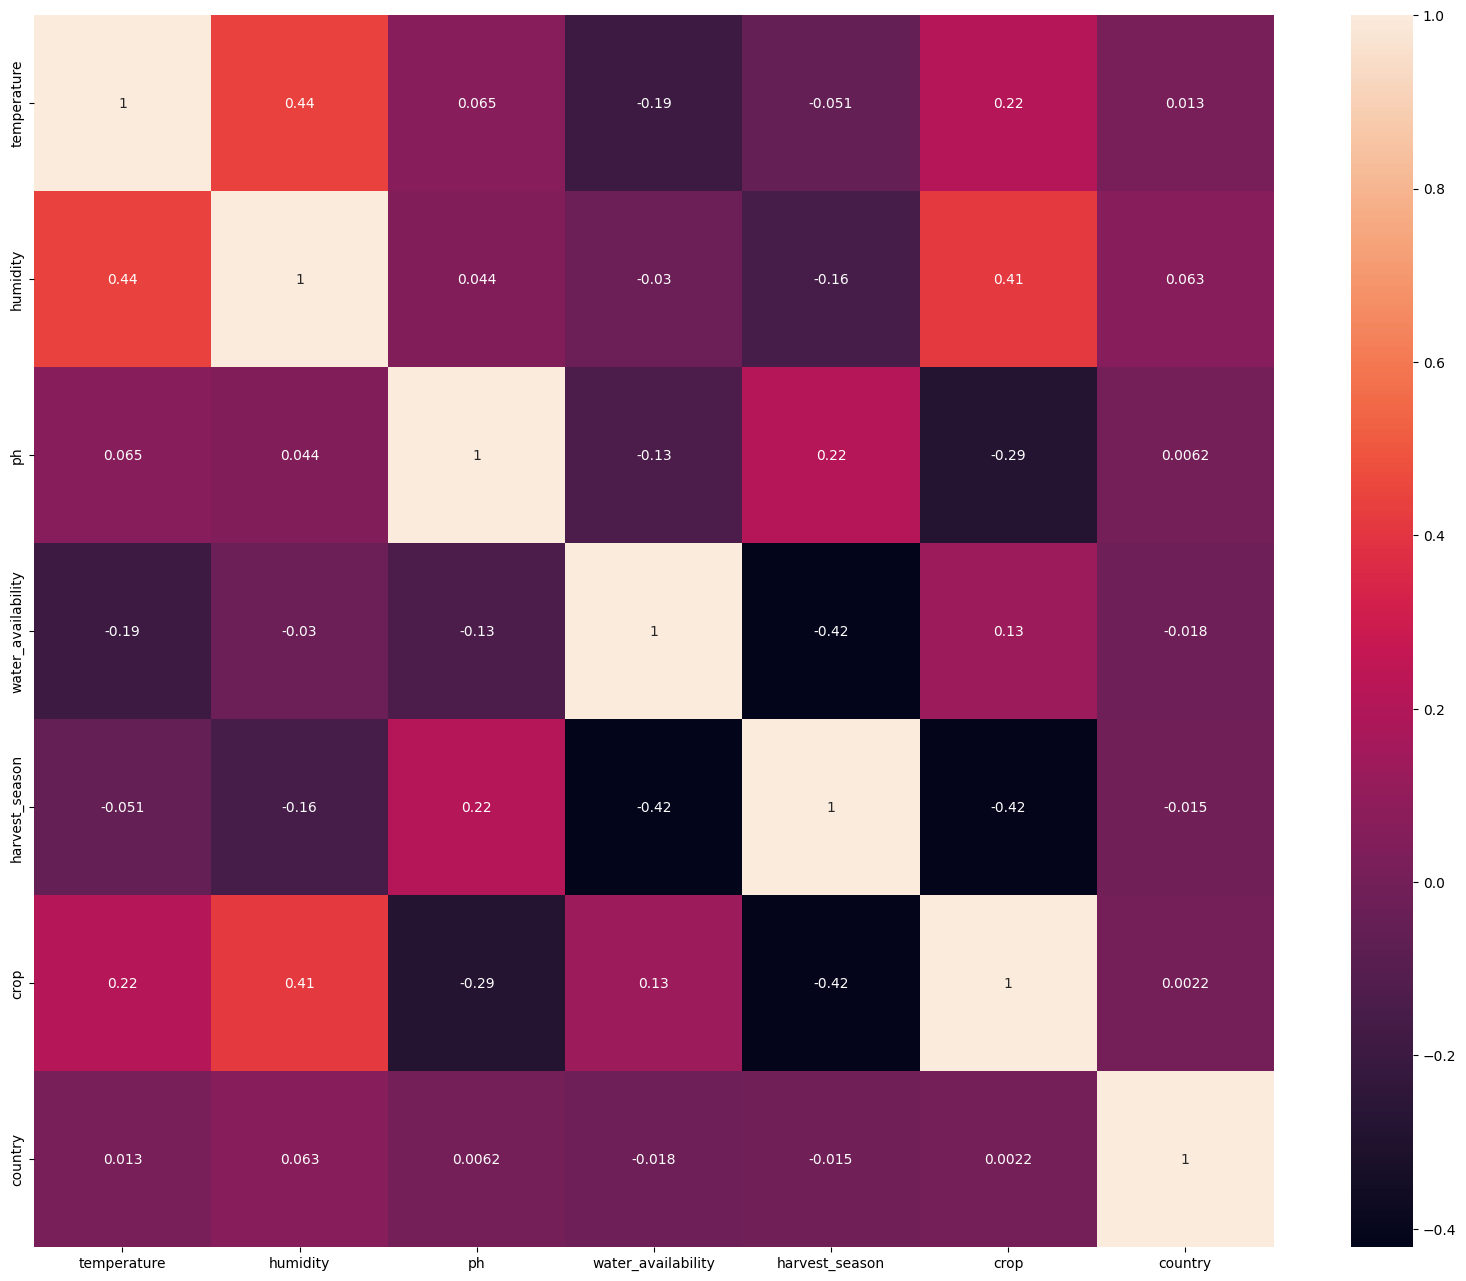

In [23]:
plt.figure(figsize=(20, 16))
sn.heatmap(season_df.corr(), annot=True)

# prediction of harvest season

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)
#s_train, s_test, p_train, p_test = train_test_split(season_df, )

In [25]:
X_test

,temperature,humidity,ph,water_availability,crop,country
547,30.992569,43.021514,8.034413,58.276007,7,2
754,33.953091,69.961000,7.423530,61.163505,0,1
1283,24.712525,77.729311,7.979090,85.249633,2,2
1128,27.723383,90.938979,6.698469,22.818634,9,1
1063,25.832029,89.004817,6.755192,45.246906,12,2
...,...,...,...,...,...,...
664,29.129395,88.483126,7.085982,36.450128,8,1
764,30.640958,61.145086,7.167436,71.369475,0,1
239,18.811981,15.216182,6.206582,77.542942,1,2
616,27.864013,80.451314,6.852885,42.830539,8,1


In [26]:
svc_model = SVC()
svc_model.fit(X_train, y_train)

SVC()

In [27]:
svc_pred = svc_model.predict(X_test)

print(accuracy_score(y_test, svc_pred))
print()
print(confusion_matrix(y_test, svc_pred))
print()
print(classification_report(y_test, svc_pred))
print()

0.7607142857142857

[[83  0  4 25]
 [ 0 10  0  4]
 [23  0 42 11]
 [ 0  0  0 78]]

              precision    recall  f1-score   support

       rainy       0.78      0.74      0.76       112
      spring       1.00      0.71      0.83        14
      summer       0.91      0.55      0.69        76
      winter       0.66      1.00      0.80        78

    accuracy                           0.76       280
   macro avg       0.84      0.75      0.77       280
weighted avg       0.80      0.76      0.75       280




In [28]:
rf_model = RandomForestClassifier(criterion='entropy')
rf_model.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy')

In [29]:
rf_pred = rf_model.predict(X_test)

print(accuracy_score(y_test, rf_pred))
print()
print(confusion_matrix(y_test, rf_pred))
print()
print(classification_report(y_test, rf_pred))
print()

0.8642857142857143

[[92  0  0 20]
 [ 0 14  0  0]
 [ 0  0 76  0]
 [18  0  0 60]]

              precision    recall  f1-score   support

       rainy       0.84      0.82      0.83       112
      spring       1.00      1.00      1.00        14
      summer       1.00      1.00      1.00        76
      winter       0.75      0.77      0.76        78

    accuracy                           0.86       280
   macro avg       0.90      0.90      0.90       280
weighted avg       0.86      0.86      0.86       280




In [31]:
params = {'iterations': 206, 'depth': 7, 'learning_rate': 0.0017042082150490862, 'random_strength': 0.0006069804938473378}
cat_model = CatBoostClassifier(**params, verbose = 0, random_state = 42)
cat_model.fit(X_train, y_train)

In [32]:
cat_pred = cat_model.predict(X_test)

print(accuracy_score(y_test, cat_pred))
print()
print(confusion_matrix(y_test, cat_pred))
print()
print(classification_report(y_test, cat_pred))
print()

0.9285714285714286

[[112   0   0   0]
 [  0  14   0   0]
 [  0   0  76   0]
 [ 20   0   0  58]]

              precision    recall  f1-score   support

       rainy       0.85      1.00      0.92       112
      spring       1.00      1.00      1.00        14
      summer       1.00      1.00      1.00        76
      winter       1.00      0.74      0.85        78

    accuracy                           0.93       280
   macro avg       0.96      0.94      0.94       280
weighted avg       0.94      0.93      0.93       280




CatBoostClassifier()

def objective(trial):
    # define parameters
    
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'random_strength': trial.suggest_loguniform('random_strength', 1e-5, 10)
    }
    
    model = CatBoostClassifier(**params, verbose = 0, random_state = 42, task_type='GPU')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy
    
    

study = optuna.create_study(direction= 'maximize')
study.optimize(objective)

# using optuna for hyper parameter tunning for guassian nb

def objective(trial):
    # hyper parameters for gaussian nb
    var_smoothing = trial.suggest_float('var_smoothing', 1e-10, 1e-1, log=True)

    model = GaussianNB(var_smoothing=var_smoothing)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    score = accuracy_score(y_test, pred)
    
    return score

study = optuna.create_study(direction= 'maximize')
study.optimize(objective)

In [33]:
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

GaussianNB()

In [34]:
nb_pred = nb_model.predict(X_test)

print(accuracy_score(y_test, nb_pred))
print()
print(confusion_matrix(y_test, nb_pred))
print()
print(classification_report(y_test, nb_pred))
print()

0.8321428571428572

[[87  0 21  4]
 [ 0 14  0  0]
 [ 4  0 70  2]
 [16  0  0 62]]

              precision    recall  f1-score   support

       rainy       0.81      0.78      0.79       112
      spring       1.00      1.00      1.00        14
      summer       0.77      0.92      0.84        76
      winter       0.91      0.79      0.85        78

    accuracy                           0.83       280
   macro avg       0.87      0.87      0.87       280
weighted avg       0.84      0.83      0.83       280




In [35]:
# save model
with open('cat_model.pkl', 'wb') as file:
    pickle.dump(cat_model, file)